## Exploratory

In [35]:
#imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [31]:
def parser(x):
    return datetime.strptime(''+x, '%Y-%m')

In [49]:
dataset = pd.read_csv("~\Documents\Airpassengers\Data\AirPassengers.csv", date_parser=parser, parse_dates=[0],
                     header=0,index_col=0)

In [50]:
print(dataset.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [51]:
dataset.dtypes

#Passengers    int64
dtype: object

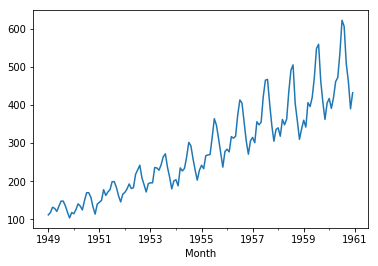

In [159]:
dataset.plot()
plt.show()

The cycles appears to be increasing, suggesting that it is multiplicative

## Time Series Decomposition

In [160]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

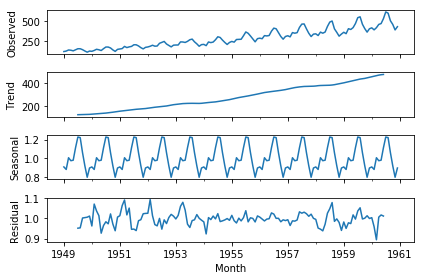

In [59]:
#a look at an additive model
result = seasonal_decompose(dataset, model='multiplicative')
result.plot()
pyplot.show()

Things we observe
* There is an increasing trend, therefore time series is not stationary
* Evidence of seasonality
* Residual plot shows periods of high variation in the early stages

In [167]:
#test for stationarity
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dataset, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Results of Dickey-Fuller Test:


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64

Fail to reject the null hypothesis that states: the series is non-stationary

## Autocorrelation and Partical Autocorrelation 

In [62]:
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 864x576 with 0 Axes>

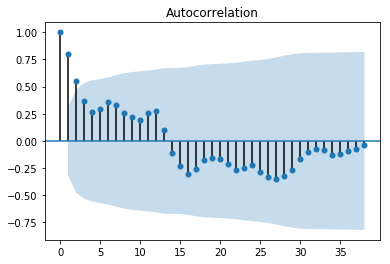

In [158]:
plt.figure(figsize=(12,8))
plot_acf(dataset[1:40])
plt.show()

## ARIMA

In [148]:
from statsmodels.tsa.arima_model import ARIMA
from scipy.optimize import brute
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [91]:
size = int(len(dataset) * 0.80)

In [92]:
train, test = dataset[0:size], dataset[size:len(dataset)]

In [93]:
len(train), len(test)

(115, 29)

In [103]:
model = auto_arima(train, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=758.546, BIC=771.671, Fit time=0.657 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=759.772, BIC=765.022, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=757.667, BIC=768.167, Fit time=0.721 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=758.296, BIC=768.796, Fit time=0.453 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=757.438, BIC=765.313, Fit time=0.163 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=757.897, BIC=768.397, Fit time=0.708 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=759.572, BIC=772.697, Fit time=0.673 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=758.709, BIC=769.209, Fit time=0.199 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=757.961, BIC=768.461, Fit time=0.312 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 

In [108]:
model.aic(), model.bic()

(757.4381095588851, 765.3130279987379)

Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12)

In [109]:
model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [110]:
preds = model.predict(n_periods= len(test))

In [131]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

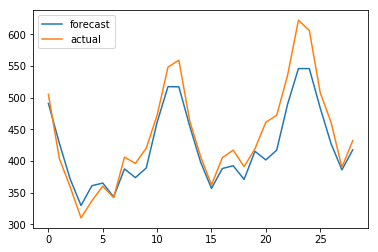

In [128]:
plt.plot(preds, label = 'forecast')
plt.plot(np.array(test), label ='actual')
plt.legend()
plt.show()

In [142]:
rmse = mean_squared_error(test, preds)
rmse

970.9680678911975

## Rolling Forecast SARIMAX

In [150]:
#generates predictions


history = [x for x in train]
predictions = list()
def predict(mylist):
    for t in range(len(test)):
        model = SARIMAX(history, order=(1,1,0), seasonal_order=(0, 1, 0, 12))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)

In [151]:
# Let's create a helper function to calculate some correlations.

# A reminder from Statistcs 101: A Pearson correlation coefficient is a measure of association between two continuous, normally-distributed variables. 
# The coefficient value can vary between -1 to 1. -1 indicates a perfect negative/inverse correlation between two variables, 
# while 0 indicates no correlation, and 1 indicates a perfect positive correlation. This coefficient also comes with a p-value, measuring statistical significance.
# A smaller p-value indicates greater statistical significance (with values below 0.05 generally being used as a threshold for significance).

def clean_corr(corr_results):
    """
    Takes the output of the scipy.stats.pearsonr function (Pearson correlation) and cleans it up for easy viewing
    
    Args:
        corr_results: Tuple of floats, the output from scipy.stats.pearsonr
        
    Returns: None
    """
    print(f"r = {round(corr_results[0], 3)} (p =  {round(corr_results[1], 3)})")

300.99958021955337

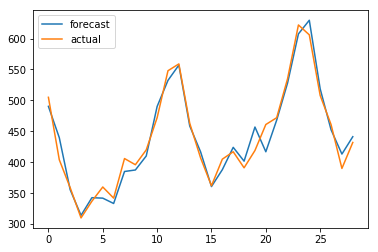

In [152]:
plt.plot(predictions, label = 'forecast')
plt.plot(np.array(test), label ='actual')
plt.legend()
plt.show()

Rolling forecast does not use as fixed period for the forecast. 